# Filtering Margin Catalogs and Skymaps

By Sean McGuire
In this notebook, we demonstrate how spatial filters work when being performed on margin catalogs, and the skymap feature.

In [1]:
import lsdb
import numpy as np
import hipscat as hc
from hipscat.pixel_math import HealpixPixel
from hipscat.pixel_math.filter import get_filtered_pixel_list
from hipscat.inspection import plot_pixel_list
from hipscat.pixel_tree.pixel_tree_builder import PixelTreeBuilder
from lsdb.core.search import ConeSearch
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import healpy as hp

In [2]:
from distributed import Client

client = Client(n_workers=6, memory_limit='10GB', local_directory="/data3/epyc/projects3/sean_hipscat", dashboard_address=':39948', threads_per_worker=1)
client

/astro/users/seanmcgu/anaconda3/envs/lsdb/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 39948 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43373 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43373/status,
Dashboard: http://127.0.0.1:43373/status,Workers: 6
Total threads: 6,Total memory: 55.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37397,Workers: 6
Dashboard: http://127.0.0.1:43373/status,Total threads: 6
Started: Just now,Total memory: 55.88 GiB
Comm: tcp://127.0.0.1:46660,Total threads: 1
Dashboard: http://127.0.0.1:34710/status,Memory: 9.31 GiB
Nanny: tcp://127.0.0.1:36255,


### Reading Catalogs

In [3]:
ssm = lsdb.read_hipscat("/astro/users/seanmcgu/lsdb_deploy/tests/data/small_sky_xmatch_margin")
ssm

,id,ra,dec,ra_error,dec_error,calculated_dist,Norder,Dir,Npix,margin_Norder,margin_Dir,margin_Npix
npartitions=5,,,,,,,,,,,,
4611686018427387904,int64,float64,float64,float64,float64,float64,uint8,uint64,uint64,uint8,uint64,uint64
12682136550675316736,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
13546827679130451968,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
ss = lsdb.read_hipscat("/astro/users/seanmcgu/lsdb_deploy/tests/data/small_sky_xmatch", margin_cache=ssm)
ss

,id,ra,dec,ra_error,dec_error,calculated_dist,Norder,Dir,Npix
npartitions=3,,,,,,,,,
12682136550675316736,int64,float64,float64,float64,float64,float64,uint8,uint64,uint64
12970366926827028480,...,...,...,...,...,...,...,...,...
13258597302978740224,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...


In [5]:
ztf = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")
ztf

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,Norder,Dir,Npix
npartitions=2352,,,,,,,,,,,,,,,
0,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32
18014398509481984,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13830554455654793216,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Margin Spatial Filters

The problem with spatial filters on a margin catalog is that the filter may include points in the margin of a pixel even though the filter does not intersect with the pixel itself. This would mean the current way we do the coarse part of the spatial filtering of using only the partitions that intersect with the filter region would not work.

In [36]:
order = 1
pixel = 45

cra = -38
cdec = -60
radius = 8

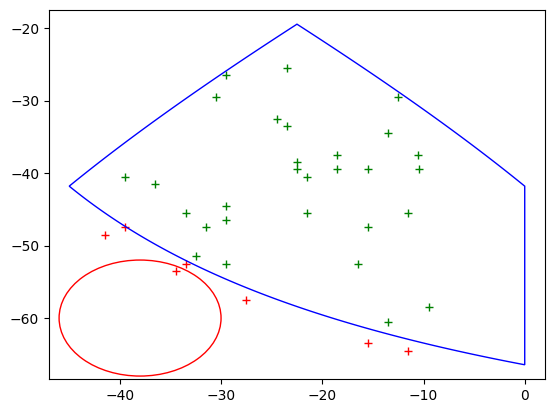

In [37]:
def plot_points(pixel_dfs, order, pixel, colors, ra_columns, dec_columns, xlim=None, ylim=None, alpha=1, circle=False):
    ax = plt.subplot()

    # Plot hp pixel bounds
    nsides = hp.order2nside(order)
    pix0_bounds = hp.vec2dir(hp.boundaries(nsides, pixel, step=100, nest=True), lonlat=True)
    lon = pix0_bounds[0]
    lat = pix0_bounds[1]
    vertices = np.vstack([lon.ravel(), lat.ravel()]).transpose()
    p = Polygon(vertices, closed=True, edgecolor='blue', facecolor='none')

    for pixel_df, color, ra_column, dec_column in zip(pixel_dfs, colors, ra_columns, dec_columns):
        ax.scatter(pixel_df[ra_column].values - 360, pixel_df[dec_column].values, c=color, marker='+', linewidths=1, alpha=alpha)
    ax.add_patch(p)

    if circle:
        circle = plt.Circle((cra, cdec), radius, color='red', fill=False)
        ax.add_artist(circle)

    VIEW_MARGIN = 2

    xlim_low = np.min(lon) - VIEW_MARGIN if xlim is None else xlim[0]
    xlim_high = np.max(lon) + VIEW_MARGIN if xlim is None else xlim[1]
    ylim_low = np.min(lat) - VIEW_MARGIN if ylim is None else ylim[0]
    ylim_high = np.max(lat) + VIEW_MARGIN if ylim is None else ylim[1]

    plt.xlim(xlim_low, xlim_high)
    plt.ylim(ylim_low, ylim_high)
    plt.show()

plot_points([ss.get_partition(order, pixel).compute(), ss.margin.get_partition(order, pixel).compute()], order, pixel, ['green', 'red'], ['ra', 'ra'], ['dec', 'dec'], circle=True)

This example of a cone search shows the issue. The pixel and its margin cache are plotted above, along with an example of a cone search that would capture some of the margin points. However, since the cone does not intersect with the pixel itself, the pixel and these margin points would normally not be included in the resulting catalog.

### The solution

To solve this, we need to include not only the pixels that overlap with the filter region, but also any pixels that neighbor those pixels. We can reuse the code from the margin cache generation to find these pixels.

First, let's plot the pixels that would normally be filtered by a search

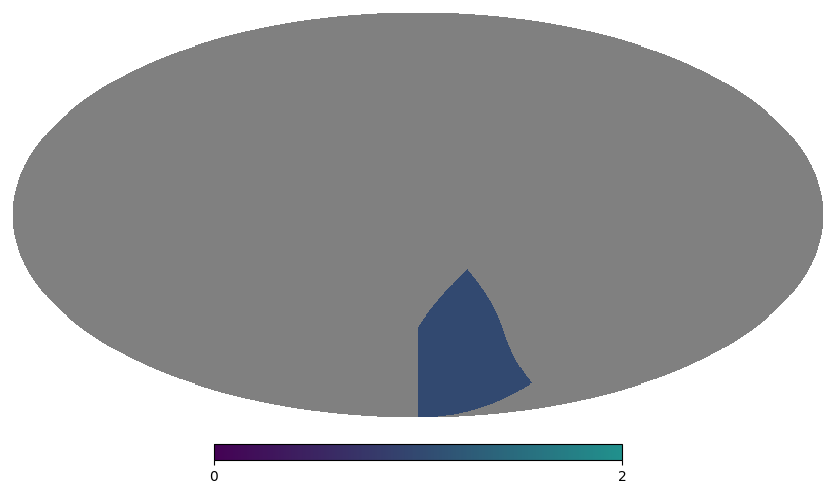

In [41]:
search = ConeSearch(cra, cdec, radius * 3600, ss.margin.hc_structure) # Get the pixels that match the search pixels
filtered_search_pixels = search.search_partitions(ss.margin.hc_structure.get_healpix_pixels())
plot_pixel_list(filtered_search_pixels)

Now let's get the set of pixels that border all of the pixels in this region

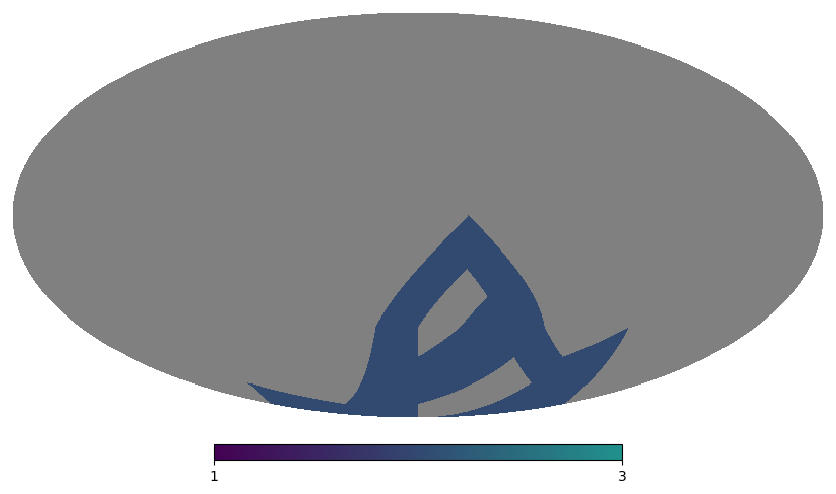

In [43]:
# Get the margin pixels at the max order + 1 from the search pixels
# the get_margin function requires a higher order than the given pixel
margin_order = max(pixel.order for pixel in filtered_search_pixels) + 1
margin_pixels = [
    hc.pixel_math.get_margin(pixel.order, pixel.pixel, margin_order - pixel.order)
    for pixel in filtered_search_pixels
]

# Remove duplicate margin pixels and construct HealpixPixel objects
margin_pixels = list(set(np.concatenate(margin_pixels)))
margin_pixels = [HealpixPixel(margin_order, pixel) for pixel in margin_pixels]
plot_pixel_list(margin_pixels)

Finally, we combine these pixels and the regular pixels and align them to the catalog we want to filter

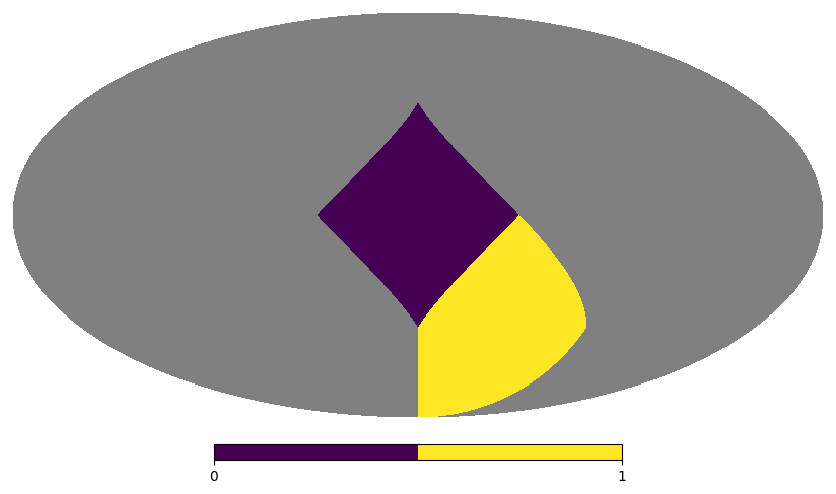

In [44]:
# Align the margin pixels with the catalog pixels and combine with the search pixels
margin_pixel_tree = PixelTreeBuilder.from_healpix(margin_pixels)
filtered_margin_pixels = get_filtered_pixel_list(ss.margin.hc_structure.pixel_tree, margin_pixel_tree)
filtered_pixels = list(set(filtered_search_pixels + filtered_margin_pixels))

plot_pixel_list(filtered_pixels)

With this implemented in the margin catalog's search method, we can now correctly perform spatial filters on the margin. When a catalog with a margin has a spatial filter called, the resulting catalog will include the filtered maragin catalog

In [46]:
searched_ss = ss.cone_search(cra, cdec, radius*3600)
searched_ss.margin

,id,ra,dec,ra_error,dec_error,calculated_dist,Norder,Dir,Npix,margin_Norder,margin_Dir,margin_Npix
npartitions=5,,,,,,,,,,,,
4611686018427387904,int64,float64,float64,float64,float64,float64,uint8,uint64,uint64,uint8,uint64,uint64
12682136550675316736,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
13546827679130451968,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...


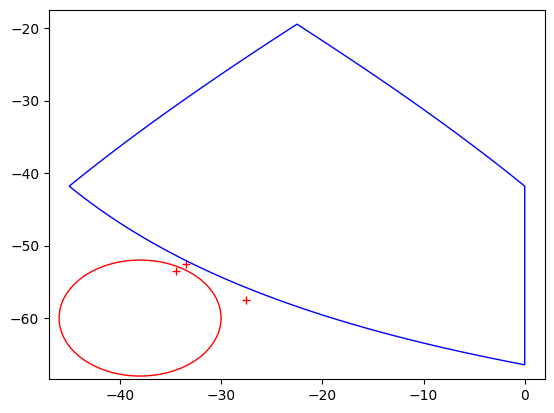

In [47]:
plot_points([searched_ss.get_partition(order, pixel).compute(), searched_ss.margin.get_partition(order, pixel).compute()], order, pixel, ['green', 'red'], ['ra', 'ra'], ['dec', 'dec'], circle=True)

We see that we now include the margin points that are within the cone (The diagram isn't perfect and there are extra points because the circle doesn't actually represent the correct cone area on the sphere)

## Skymap

The skymap function applies a specified user function to each partition in the dataset, then plots the results for each partition on a Mollweide projection of the pixels coloured by the values

In [10]:
def density(df, pixel):
    return len(df) / hp.nside2pixarea(2 ** pixel.order)

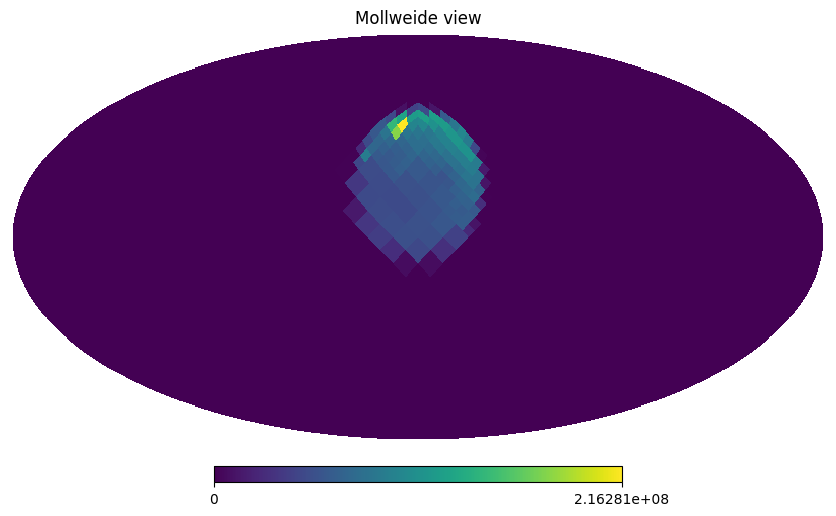

In [11]:
ztf.cone_search(0, 20, 100000).skymap(density)

In [8]:
def length(df, _):
    return len(df)

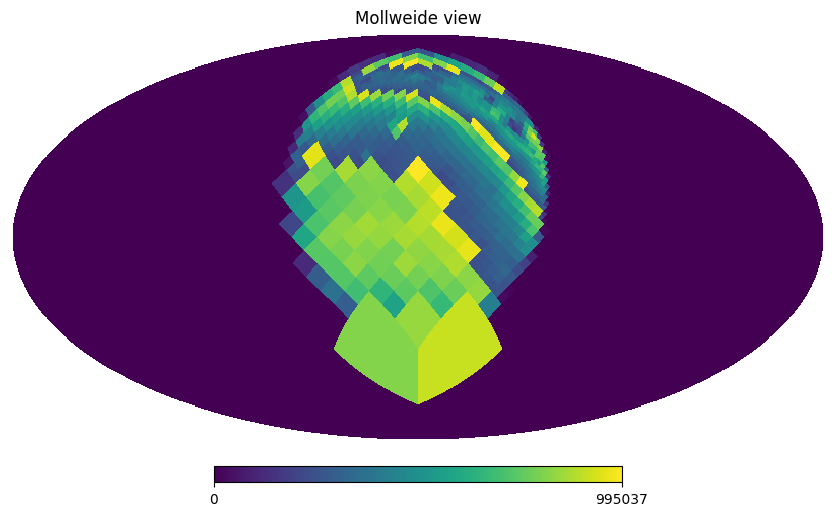

In [12]:
ztf.cone_search(0, 20, 200000).skymap(length)

In [55]:
def brightness(df, pixel):
    return df["mean_mag_r"].sum() / hp.nside2pixarea(2 ** pixel.order) 

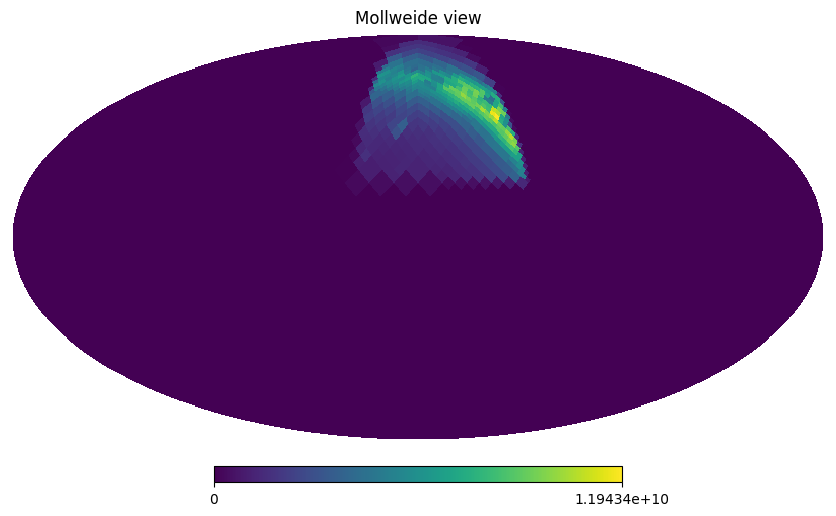

In [59]:
ztf.box(ra=[-50, 30], dec=[20, 90]).skymap(brightness)